LOADING LIBRARIES

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import pos_tag, ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from better_profanity import profanity
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
import emoji
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
from transformers import pipeline
from wordcloud import WordCloud

LOADING DATA - COMMENTS OF SUPREME POSTS

In [2]:
#links from which comments were taken
"https://www.instagram.com/p/BV62b5PjtT-/" #January 19, 2017

'https://www.instagram.com/p/BV62b5PjtT-/'

In [3]:
#loading excels, where comments were saved
post_1 = pd.read_excel("instagram-lv.xlsx")

BASIC DATA PREPROCESSING AND MODELING

In [4]:
post_1 = post_1.iloc[:, 2:-1]

# Set the first row as the header
post_1.columns = post_1.iloc[0]

# Remove the first row after setting it as the header
post_1 = post_1[1:]
post_comment_1 = post_1[['Date', 'Comment']]


In [5]:
print("Shape of post_comment_1:", post_comment_1.shape)

Shape of post_comment_1: (1150, 2)


PLOTTING DATA

C:\Users\sofiia.vernydub\AppData\Local\Temp\ipykernel_29428\2454309508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_comment_1['Date'] = pd.to_datetime(post_comment_1['Date'])
C:\Users\sofiia.vernydub\AppData\Local\Temp\ipykernel_29428\2454309508.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_comment_1['Year'] = post_comment_1['Date'].dt.year


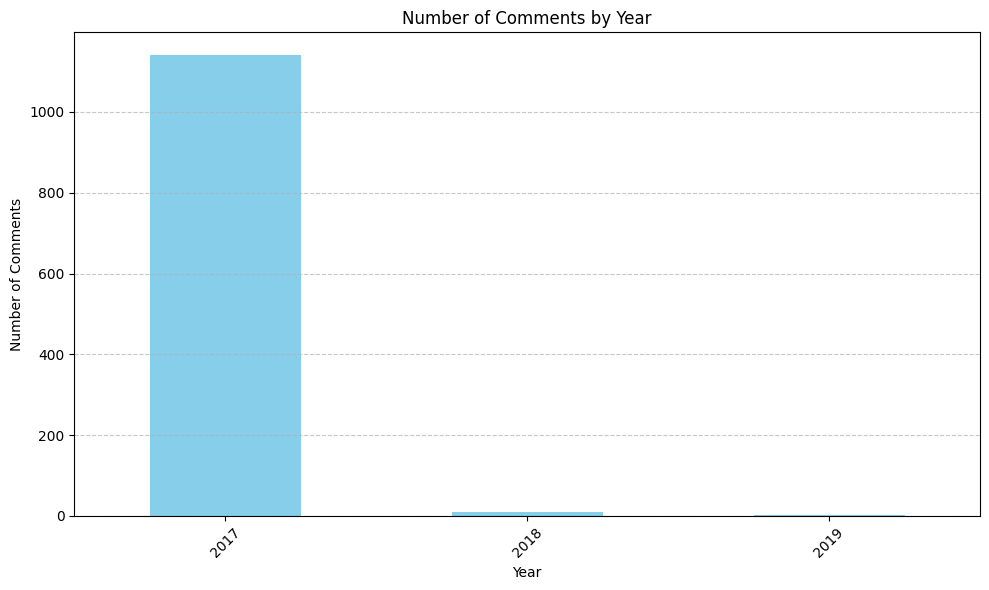

In [6]:
# Convert 'Date' column to datetime format
post_comment_1['Date'] = pd.to_datetime(post_comment_1['Date'])

# Extract year from the 'Date' column
post_comment_1['Year'] = post_comment_1['Date'].dt.year

# Group by year and count the number of comments
comment_counts = post_comment_1.groupby('Year').size()

# Plotting
plt.figure(figsize=(10, 6))
comment_counts.plot(kind='bar', color='skyblue')

plt.xlabel('Year')
plt.ylabel('Number of Comments')
plt.title('Number of Comments by Year')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

APPENDING DATA

In [7]:
all_post_comments_df = post_comment_1
all_post_comments_df.reset_index(inplace=True)
all_post_comments_df['Date'] = pd.to_datetime(all_post_comments_df['Date'])
all_post_comments_df['Date'] = all_post_comments_df['Date'].dt.strftime('%d-%m-%Y')
all_post_comments_df.drop(columns=['index', 'Year'], inplace=True)

C:\Users\sofiia.vernydub\AppData\Local\Temp\ipykernel_29428\2403360411.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_post_comments_df['Date'] = pd.to_datetime(all_post_comments_df['Date'])
C:\Users\sofiia.vernydub\AppData\Local\Temp\ipykernel_29428\2403360411.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_post_comments_df['Date'] = all_post_comments_df['Date'].dt.strftime('%d-%m-%Y')
C:\Users\sofiia.vernydub\AppData\Local\Temp\ipykernel_29428\2403360411.py:5: SettingWithCopyWarning: 
A va

In [8]:
all_post_comments_df[:5]

,Date,Comment
0,29-06-2017,Gt
1,29-06-2017,Wow
2,29-06-2017,💚
3,29-06-2017,⚡️⚡️⚡️
4,29-06-2017,Wishing I had money😴


DATA PREPROCESING - PREPAIRING COMMENTS FOR SENTIMENT ANALYSIS

In [9]:
# Removing usernames from each comments, usernames start with @
def remove_usernames(comment):
    return re.sub(r'@\w+(\.\w+)*\s*', '', comment)
all_post_comments_df['Cleaned Comment'] = all_post_comments_df['Comment'].astype(str)
all_post_comments_df['Cleaned Comment'] = all_post_comments_df['Cleaned Comment'].apply(remove_usernames)

# Define a function to remove URLs
def remove_urls(comment):
    return re.sub(r'http\S+', '', comment)
all_post_comments_df['Cleaned Comment'] = all_post_comments_df['Cleaned Comment'].apply(remove_urls)

# Convert text to lowercase
all_post_comments_df['Cleaned Comment'] = all_post_comments_df['Cleaned Comment'].str.lower()

# Remove punctuation marks
all_post_comments_df['Cleaned Comment'] = all_post_comments_df['Cleaned Comment'].str.replace('[^\w\s]', '')

# Removing empty and whitespace-only rows
all_post_comments_df['Cleaned Comment'] = all_post_comments_df['Cleaned Comment'].str.strip()  # Remove leading and trailing whitespaces
all_post_comments_df = all_post_comments_df.dropna(subset=['Cleaned Comment'])  # Drop NaN values
all_post_comments_df = all_post_comments_df[all_post_comments_df['Cleaned Comment'] != '']  # Remove empty strings
all_post_comments_df.reset_index(drop=True, inplace=True)

C:\Users\sofiia.vernydub\AppData\Local\Temp\ipykernel_29428\2296123199.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_post_comments_df['Cleaned Comment'] = all_post_comments_df['Comment'].astype(str)
C:\Users\sofiia.vernydub\AppData\Local\Temp\ipykernel_29428\2296123199.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_post_comments_df['Cleaned Comment'] = all_post_comments_df['Cleaned Comment'].apply(remove_usernames)
C:\Users\sofiia.vernydub\AppData\Local\Temp\ipykernel_29428\2296123199.py:

profanity

In [10]:
def censored_profanity(comment):
    return profanity.censor(comment)
all_post_comments_df['Cleaned Comment'] = all_post_comments_df['Cleaned Comment'].apply(censored_profanity)

In [11]:
all_post_comments_df[:30]

,Date,Comment,Cleaned Comment
0,29-06-2017,Gt,gt
1,29-06-2017,Wow,wow
2,29-06-2017,💚,💚
3,29-06-2017,⚡️⚡️⚡️,⚡️⚡️⚡️
4,29-06-2017,Wishing I had money😴,wishing i had money😴
5,29-06-2017,Real dope,real dope
6,29-06-2017,Hot,hot
7,29-06-2017,🔥🔥🔥,🔥🔥🔥
8,29-06-2017,♥️,♥️
9,29-06-2017,@ale_magni ci vai?,ci vai?


Model 1 - j-hartmann/sentiment-roberta

In [12]:
# Load model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/sentiment-roberta-large-english-3-classes")
model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/sentiment-roberta-large-english-3-classes")

# Load sentiment analysis pipeline
sentiment_analysis = pipeline("text-classification", model=model, tokenizer=tokenizer)

def analyze_sentiment(comment):
    sentiment = sentiment_analysis(comment)[0]
    return sentiment['label'], sentiment['score']

# Apply sentiment analysis to each comment in the DataFrame
all_post_comments_df['Sentiment.Model 1'], all_post_comments_df['Confidence Score.Model 1'] = zip(*all_post_comments_df['Cleaned Comment'].map(analyze_sentiment))

# Print the DataFrame with sentiment analysis results
all_post_comments_df[:10]


Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,Date,Comment,Cleaned Comment,Sentiment.Model 1,Confidence Score.Model 1
0,29-06-2017,Gt,gt,neutral,0.975148
1,29-06-2017,Wow,wow,positive,0.982187
2,29-06-2017,💚,💚,positive,0.995898
3,29-06-2017,⚡️⚡️⚡️,⚡️⚡️⚡️,neutral,0.435315
4,29-06-2017,Wishing I had money😴,wishing i had money😴,negative,0.999216
5,29-06-2017,Real dope,real dope,positive,0.999604
6,29-06-2017,Hot,hot,positive,0.999337
7,29-06-2017,🔥🔥🔥,🔥🔥🔥,positive,0.999669
8,29-06-2017,♥️,♥️,positive,0.998758
9,29-06-2017,@ale_magni ci vai?,ci vai?,neutral,0.999250


In [13]:
# Calculate sentiment score for each label
label_sentiment_score_model_2 = all_post_comments_df.groupby('Sentiment.Model 1')['Confidence Score.Model 1'].mean()

print("Sentiment Scores for Model 1 - j-hartmann/sentiment-roberta")
print(label_sentiment_score_model_2)

Sentiment Scores for Model 1 - j-hartmann/sentiment-roberta
Sentiment.Model 1
negative    0.96680
neutral     0.98267
positive    0.98100
Name: Confidence Score.Model 1, dtype: float64


In [14]:
# Calculate sentiment labels
label_sentiment_count_model_2 = all_post_comments_df.groupby('Sentiment.Model 1')['Cleaned Comment'].count()

print("Sentiment Scores of Model 1 - j-hartmann/sentiment-roberta:")
print(label_sentiment_count_model_2)

Sentiment Scores of Model 1 - j-hartmann/sentiment-roberta:
Sentiment.Model 1
negative    110
neutral     479
positive    321
Name: Cleaned Comment, dtype: int64


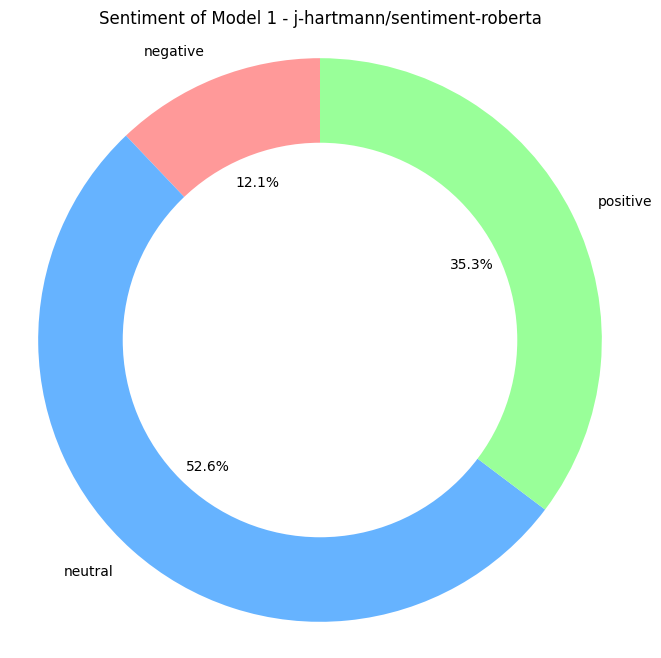

In [15]:
# Grouping the data by 'Sentiment Label.Model 1' and counting the occurrences
label_sentiment_count_model_2 = all_post_comments_df.groupby('Sentiment.Model 1')['Cleaned Comment'].count()

# Plotting the donut chart
plt.figure(figsize=(8, 8))
plt.pie(label_sentiment_count_model_2, labels=label_sentiment_count_model_2.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("Sentiment of Model 1 - j-hartmann/sentiment-roberta")
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white')) # Donut chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Model 2 - cardiffnlp/twitter-roberta-base-sentiment-latest

In [16]:
#Labels: 0 -> Negative; 1 -> Neutral; 2 -> Positive

# Load model 
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
# Create a sentiment analysis pipeline
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Assuming your DataFrame is named all_post_comments_df and contains a 'Comment' column
all_post_comments_df['Sentiment.Model 2'] = ""
all_post_comments_df['Score.Model 2'] = ""

# Iterate over each comment in the DataFrame and perform sentiment analysis
for index, row in all_post_comments_df.iterrows():
    comment = row['Cleaned Comment']
    result = pipe(comment)
    all_post_comments_df.at[index, 'Sentiment.Model 2'] = result[0]['label']
    all_post_comments_df.at[index, 'Confidence Score.Model 2'] = result[0]['score']

# Define a function to map sentiment labels to categories
def map_sentiment_label(sentiment_label):
    if sentiment_label == 'LABEL_0':
        return 'Negative'
    elif sentiment_label == 'LABEL_1':
        return 'Neutral'
    elif sentiment_label == 'LABEL_2':
        return 'Positive'
    else:
        return 'Unknown'

all_post_comments_df[:10]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,Date,Comment,Cleaned Comment,Sentiment.Model 1,Confidence Score.Model 1,Sentiment.Model 2,Score.Model 2,Confidence Score.Model 2
0,29-06-2017,Gt,gt,neutral,0.975148,neutral,,0.628388
1,29-06-2017,Wow,wow,positive,0.982187,positive,,0.500310
2,29-06-2017,💚,💚,positive,0.995898,positive,,0.860686
3,29-06-2017,⚡️⚡️⚡️,⚡️⚡️⚡️,neutral,0.435315,positive,,0.598759
4,29-06-2017,Wishing I had money😴,wishing i had money😴,negative,0.999216,neutral,,0.372274
5,29-06-2017,Real dope,real dope,positive,0.999604,positive,,0.676893
6,29-06-2017,Hot,hot,positive,0.999337,positive,,0.464384
7,29-06-2017,🔥🔥🔥,🔥🔥🔥,positive,0.999669,positive,,0.891028
8,29-06-2017,♥️,♥️,positive,0.998758,positive,,0.932660
9,29-06-2017,@ale_magni ci vai?,ci vai?,neutral,0.999250,neutral,,0.844906


In [17]:
label_sentiment_count_model_3 = all_post_comments_df.groupby('Sentiment.Model 2')['Cleaned Comment'].count()

print("Sentiment Scores of Model 2 - cardiffnlp/twitter-roberta-base-sentiment-latest:")
print(label_sentiment_count_model_3)

Sentiment Scores of Model 2 - cardiffnlp/twitter-roberta-base-sentiment-latest:
Sentiment.Model 2
negative     66
neutral     538
positive    306
Name: Cleaned Comment, dtype: int64


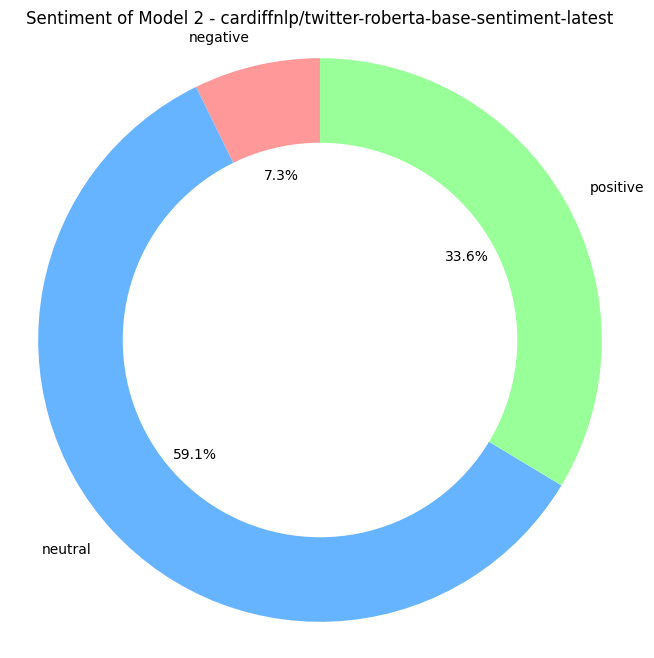

In [18]:
# Grouping the data by 'Sentiment Label.Model 1' and counting the occurrences
label_sentiment_count_model_3 = all_post_comments_df.groupby('Sentiment.Model 2')['Cleaned Comment'].count()

# Plotting the donut chart
plt.figure(figsize=(8, 8))
plt.pie(label_sentiment_count_model_3, labels=label_sentiment_count_model_3.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("Sentiment of Model 2 - cardiffnlp/twitter-roberta-base-sentiment-latest")
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white')) # Donut chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [19]:
# Compare predictions of Sentiment.Label.Model 1 and Sentiment.Label.Model 2
all_post_comments_df['Prediction_Match'] = all_post_comments_df['Sentiment.Model 1'] == all_post_comments_df['Sentiment.Model 2']

# Filter rows where predictions do not match
mismatched_predictions = all_post_comments_df[~all_post_comments_df['Prediction_Match']]

# Count the number of mismatched predictions
mismatch_count = len(mismatched_predictions)

# Set the maximum number of rows to display
pd.set_option('display.max_rows', None)

# Display rows where predictions do not match
print("Cases where predictions of Sentiment.Model 1 and Sentiment.Model 2 do not match:")
print("Number of mismatched predictions:", mismatch_count)

Cases where predictions of Sentiment.Model 1 and Sentiment.Model 2 do not match:
Number of mismatched predictions: 167


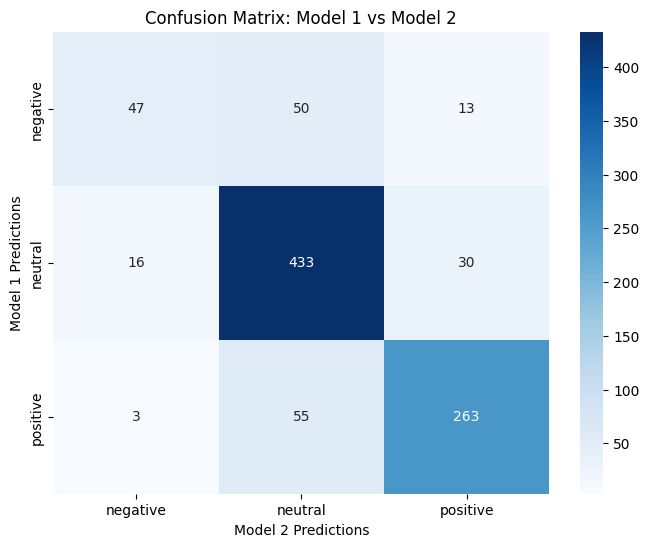

In [20]:
# Confusion matrix
confusion_matrix_both_models = pd.crosstab(all_post_comments_df['Sentiment.Model 1'], all_post_comments_df['Sentiment.Model 2'], rownames=['Model 1'], colnames=['Model 2'])

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_both_models, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.title('Confusion Matrix: Model 1 vs Model 2')
plt.xlabel('Model 2 Predictions')
plt.ylabel('Model 1 Predictions')
plt.show()

In [21]:
confusion_matrix_both_models

Model 2,negative,neutral,positive
Model 1,,,
negative,47,50,13
neutral,16,433,30
positive,3,55,263


emojiis

In [22]:
# Extracting emojis from each comment
def extract_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.findall(text)


all_post_comments_df['Emojis'] = all_post_comments_df['Comment'].astype(str).apply(extract_emojis)

# Creating a list of all emojis
all_emojis = all_post_comments_df['Emojis'].explode().dropna().unique()

# Creating a DataFrame with unique emojis
emojis_df = pd.DataFrame(all_emojis, columns=['Emoji'])

# Step 1: Convert emojis to sets to get unique emojis
emojis_df['Unique_Emojis'] = emojis_df['Emoji'].apply(lambda x: set(x))

# Step 2: Flatten the sets to create a list of unique emojis
unique_emojis = [emoji for emojis_set in emojis_df['Unique_Emojis'] for emoji in emojis_set]

# Step 3: Count the occurrence of each unique emoji
emoji_counts = {}
for emoji in unique_emojis:
    if emoji in emoji_counts:
        emoji_counts[emoji] += 1
    else:
        emoji_counts[emoji] = 1

# Step 4: Create a DataFrame for the summary table
summary_emoji_df = pd.DataFrame(list(emoji_counts.items()), columns=['Emoji', 'Count'])
summary_emoji_df = summary_emoji_df.sort_values(by='Count', ascending = False)
summary_emoji_df.reset_index(drop=True, inplace=True)
summary_emoji_df.index += 1
summary_emoji_df = summary_emoji_df[:10]

In [23]:
# Define emoji2description function
def emoji2description(emoji_char):
    try:
        return emoji.demojize(emoji_char)
    except AttributeError:
        return "No description available"

# Add 'Meaning' column
summary_emoji_df['Meaning'] = summary_emoji_df['Emoji'].apply(emoji2description)
summary_emoji_df

,Emoji,Count,Meaning
1,🏻,11,No description available
2,👍,10,No description available
3,😍,9,No description available
4,🔥,8,No description available
5,👌,7,No description available
6,👏,7,No description available
7,🏼,6,No description available
8,🔴,6,No description available
9,🙏,6,No description available
10,🔝,5,No description available


wordcloud

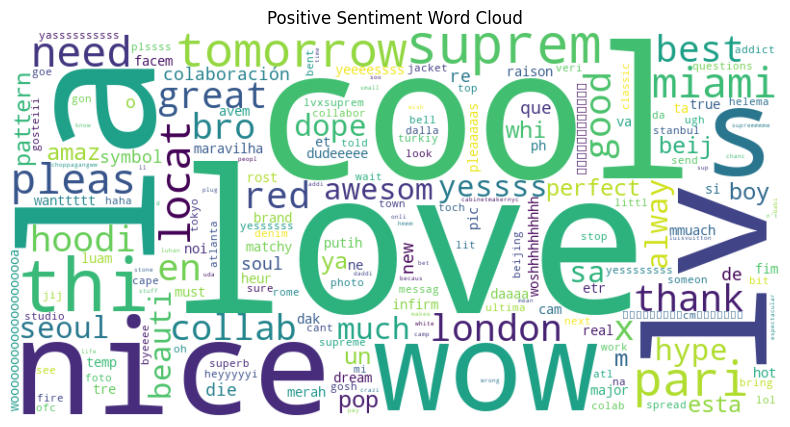

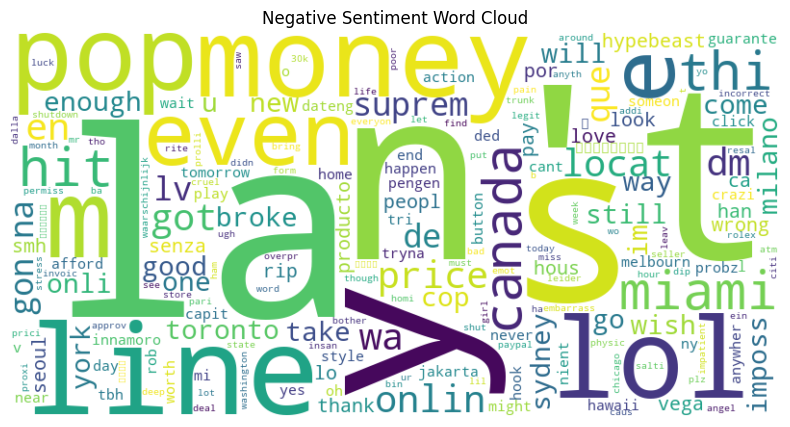

In [30]:
# Function to perform stemming
def stem_text(text):
    ps = PorterStemmer()
    words = word_tokenize(text)
    stemmed_words = [ps.stem(word) for word in words]
    return ' '.join(stemmed_words)

# positive sentiment
positive_comments = all_post_comments_df[all_post_comments_df['Sentiment.Model 1'] == 'positive']['Cleaned Comment'].tolist()

#  negative sentiment
negative_comments = all_post_comments_df[all_post_comments_df['Sentiment.Model 1'] == 'negative']['Cleaned Comment'].tolist()

# Join positive and negative comments 
positive_text = ' '.join(positive_comments)
negative_text = ' '.join(negative_comments)

# stemming
positive_text_stemmed = stem_text(positive_text)
negative_text_stemmed = stem_text(negative_text)

# Word Cloud for Positive Sentiment
positive_wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(positive_text_stemmed)

#  Word Cloud for Negative Sentiment
negative_wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(negative_text_stemmed)

# Plot Positive Sentiment Word Cloud
plt.figure(figsize = (10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')
plt.show()

# Plot Negative Sentiment Word Cloud
plt.figure(figsize = (10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')
plt.show()